# Slider-crank mechanism.
```
Authors:

Manuel Julio García Ruiz, PhD
Angelo State University

Mauricio Aristizabal Cano
Univerisidad EAFIT
```
## Introduction

This document presents an application of OTI numbers to compute velocity, accelerations and general time derivatives of mechanisms. The concept consists in exploiting the capacity of OTI numbers to compute high-order derivatives, as it is used to compute time-derivatives of first (velocity), second (acceleration) and third (jerk) order.

This exercise is based on examples 4.11, 6.18 and 7.12 from [1]. In this case the goal is to perform a kinetic analysis to the compressor slider-crank mechanism as in the next figure.

[1] Myszka, David H. Machines and mechanisms. Prentice Hall, 2004.|

<img src="imgs/compressor.png" alt="Compressor prob 4.11" style="width: 500px;">

Performing a simplification of the mechanism leads to the following kinematic diagram

<img src="imgs/compressor-kin-diag.png" alt="Compressor kinematic diagram" style="width: 500px;">

which shows that this mechanism is indeed an inline slider-crank mechanism, which in general has the following characteristics:

<img src="imgs/slider-crank.png" alt="Slider crank" style="width: 400px;">

## Problem definition.

The goal is to compute the derivatives of the different variables with respect to time. As such, we need first to import the corresponding libraries, in this case: ```pyoti``` (for OTI numbers support) as well as ```matplolib``` (for plotting).

Note that importing ```pyplot``` already imports ```numpy```.

In [1]:
# 1. SET GLOBAL PATH 
import sys
path2oti = '../../../build/'
sys.path.append(path2oti) # Add path to OTI library.


import  pyoti.sparse as oti
np  = oti.np
eps = oti.e

%matplotlib notebook
import matplotlib.pyplot as plt

Next, we define the different variables. We are going to analyze the problem where L2 = 0.75, L3 = 2.00. Bar L2 retates at a *constant* angular speed of $\omega_2=1750\mbox{ rpm}$. We obviously convert rpm to rad/s, as shown below.

In [9]:
L1 = 0.00
L2 = 0.75
L3 = 2.00

w  = 1750 #rpm

# convert rpm to rad/s 
omega2 = w * 2 * np.pi / 60.0 

alpha2 = 0.0

Now, lets compute $\omega_2$. As we know, the angular speed $\omega_2$ is constant. Therefore, we know that

$$
\frac{d\theta_2}{dt} = \omega_2
$$

therefore, we know that using OTI algebra, the correct way to express this is

$$
\theta_2 ^* = \theta_2(t)+\frac{d\theta_2}{dt}\epsilon_1
$$


In [27]:
n = 100
theta2_r=np.linspace(0,2*np.pi,n) 

dT = 2 * np.pi / (n-1)
dt = dT / omega2

# Define all time evaluation points.
time = np.arange(0,dt*n,dt)
t = time + eps(1,order = 3)
theta2 = omega2*t
# theta2  =theta2_r + omega2*eps(1,order=2)

Now, using the equations of the inline slider crank mechanism, it is possible to compute the angles $\theta_3$ and $\gamma$ as follows

$$
\theta_3 = \arcsin{\left[ \frac{L2}{L3}\; \sin\left(\theta_2\right)\right]}
$$

$$
\gamma = \pi -(\theta_2+\theta_3)
$$


In [28]:
theta3 = np.arcsin( (L2/L3)*np.sin(theta2) )
gamma  = np.pi - ( theta2 + theta3 )
# theta3
# gamma

And now the distance L4 is calculated for all times as

$$
L4 = \sqrt{L2^2+L3^2-2\;L2\;L3\cos{(\gamma)}}
$$

In [29]:
# L4 = - (np.sqrt(L2**2 +L3**2 - 2*(L2) *(L3)* np.cos(gamma))-(L2+L3))
L4 = np.sqrt( L2**2 + L3**2 - 2*L2*L3*np.cos(gamma) )
# L4

Finally, the derivatives are extracted as follows:

$$
\frac{dL4}{dt} = \mbox{Im}_{\epsilon_1}\left[ L4^* \right]
$$

$$
\frac{d^2L4}{dt^2} = 2\;\mbox{Im}_{\epsilon_1^2}\left[ L4^* \right]
$$

$$
\frac{d^3L4}{dt^3} = 6\;\mbox{Im}_{\epsilon_1^3}\left[ L4^* \right]
$$

This is done with the use of the use of the method ```sotinum.get_deriv``` from the ```pyoti``` library.

In [30]:
L4_accel = np.empty_like(L4)
L4_vel   = np.empty_like(L4)
L4_jerk  = np.empty_like(L4)

theta3_accel = np.empty_like(theta3)
theta3_vel   = np.empty_like(theta3)
theta3_jerk  = np.empty_like(theta3)

for i in range(len(L4)):
    L4_vel[i]   = L4[i].get_deriv([1]) 
    L4_accel[i] = L4[i].get_deriv([1,1]) 
    L4_jerk[i]  = L4[i].get_deriv([1,1,1]) 
    
    theta3_vel[i]   = theta3[i].get_deriv([1]) 
    theta3_accel[i] = theta3[i].get_deriv([1,1]) 
    theta3_jerk[i]  = theta3[i].get_deriv([1,1,1]) 
    
    
# L4_accel
# L4_vel

## Analytic solutions

The analytic solutions of the slider-crank mechanism are the following:

$$
\omega_3 = \omega_2\frac{L2\cos{(\theta_2)}}{L3\cos{(\theta_3)}}
$$

$$
v_4 = -\omega_2\;L2\;\sin{(\theta_2)} -\omega_3\;L3\;\sin{(\theta_3)}
$$

the accelerations are the following

$$
\alpha_3 = \frac{\alpha_2\;L2\;\cos{(\theta_2)} +\omega_3^2\;L3\sin{(\theta_3)} - \omega_2^2\;L2\sin{(\theta_2)}}{L3\cos{(\theta_3)}}
$$

$$
a_4 = -\alpha_2\;L2\;\sin{(\theta_2)} -\alpha_3\;L3\;\sin{(\theta_3)}
 -\omega_2^2\;L2\;\cos{(\theta_2)}  -\omega_3^2\;L3\;\cos{(\theta_3)} 
$$

In [31]:
# Computation of analytic solutions:
theta3_r = np.arcsin((L1+L2*np.sin(theta2_r))/(L3))

L4_r     = L2*np.cos(theta2_r)+L3*np.cos(theta3_r)

omega3   = omega2*(L2*np.cos(theta2_r)/(L3*np.cos(theta3_r)))

v4       = -omega2*L2*np.sin(theta2_r)-omega3*L3*np.sin(theta3_r)

alpha3   = (-omega2**2*L2*np.sin(theta2_r) +
            omega3**2*L3*np.sin(theta3_r) +
            alpha2*L2*np.cos(theta2_r) )/(L3*np.cos(theta3_r))

alpha4   = -alpha2*L2*np.sin(theta2_r)-alpha3*L3*np.sin(theta3_r)-omega2**2*L2*np.cos(theta2_r)-omega3**2*L3*np.cos(theta3_r)

In [32]:
omega3[:10]


array([68.7223393 , 68.60338543, 68.24639887, 67.65101872, 66.81668999,
       65.74273356, 64.42844447, 62.87321867, 61.07670774, 59.03900078])

In [33]:
theta3_vel[:10]

array([68.72233929727672, 68.60338542576697, 68.24639886838678,
       67.65101872468188, 66.81668999479946, 65.74273355702402,
       64.42844447157307, 62.87321867267518, 61.07670773993315,
       59.03900078417427], dtype=object)

<IPython.core.display.Javascript object>


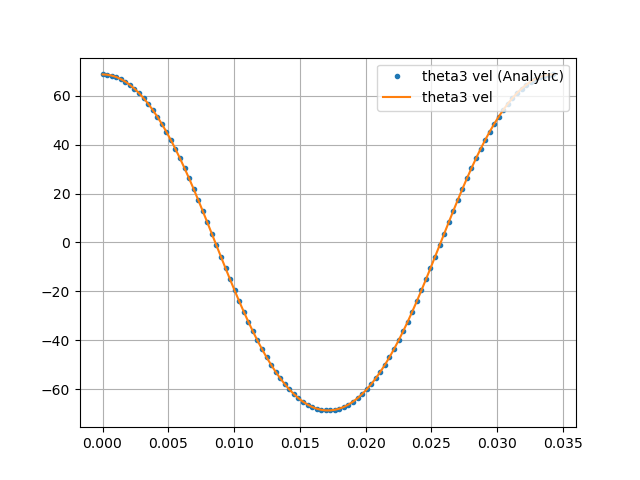

In [34]:
plt.figure()
plt.plot(time,omega3,'.',label="theta3 vel (Analytic)")
plt.plot(time,theta3_vel,label="theta3 vel")
plt.legend(bbox_to_anchor=(1, 1),loc=1)
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


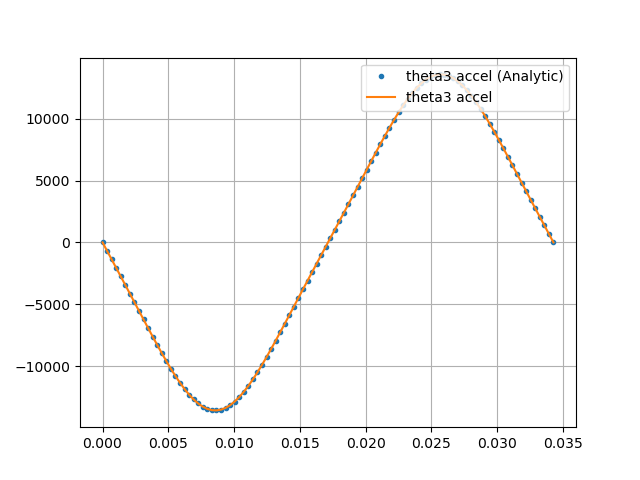

In [35]:
plt.figure()
plt.plot(time,alpha3,'.',label="theta3 accel (Analytic)")
plt.plot(time,theta3_accel,label="theta3 accel")
plt.legend(bbox_to_anchor=(1, 1),loc=1)
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


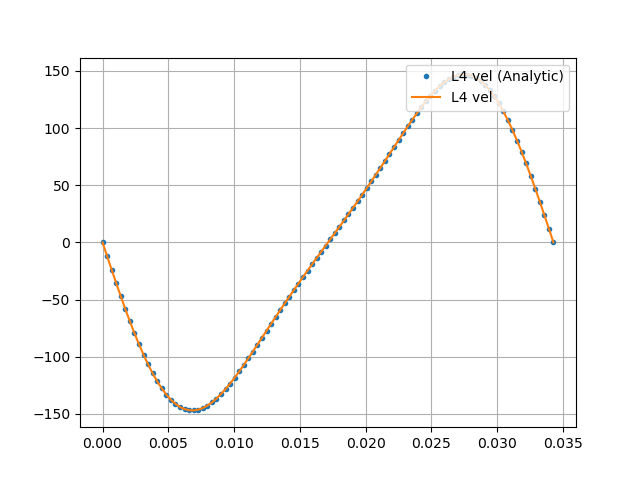

In [36]:
plt.figure()
plt.plot(time,v4,'.',label="L4 vel (Analytic)")
plt.plot(time,L4_vel,label="L4 vel")
plt.legend(bbox_to_anchor=(1, 1),loc=1)
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


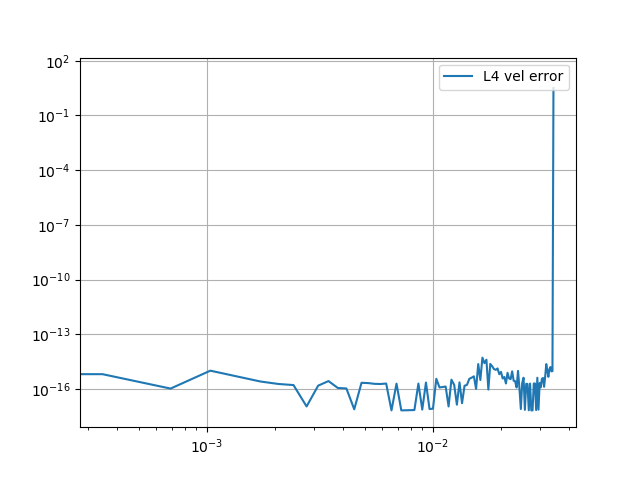

In [45]:
plt.figure()
plt.loglog(time,np.abs((v4-L4_vel+1e-15)/(v4+1e-15)),label="L4 vel error")
plt.legend(bbox_to_anchor=(1, 1),loc=1)
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


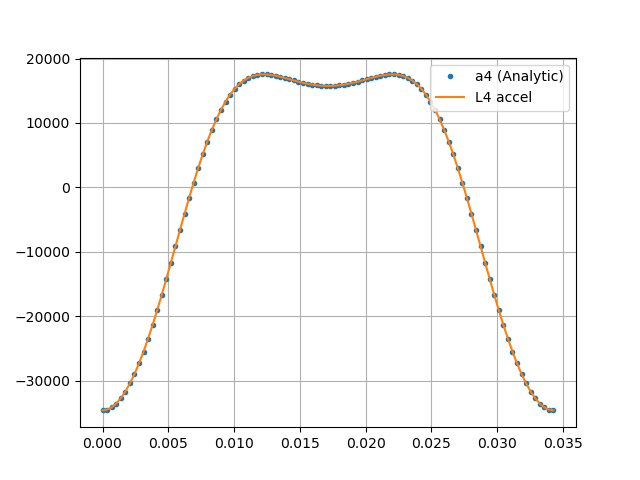

In [37]:
plt.figure()
plt.plot(time,alpha4,'.',label="a4 (Analytic)")
plt.plot(time,L4_accel,label="L4 accel")
plt.legend(bbox_to_anchor=(1, 1),loc=1)
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


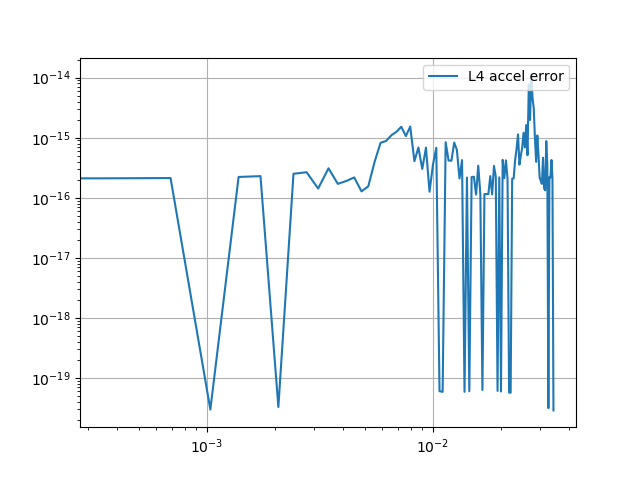

In [46]:
plt.figure()
plt.loglog(time,np.abs((alpha4-L4_accel+1e-15)/(alpha4+1e-15)),label="L4 accel error")
plt.legend(bbox_to_anchor=(1, 1),loc=1)
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


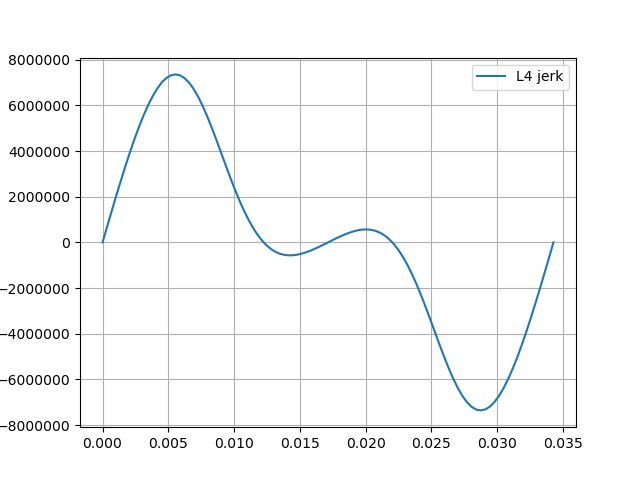

In [47]:
plt.figure()
plt.plot(time,L4_jerk,label="L4 jerk")
plt.legend(bbox_to_anchor=(1, 1),loc=1)
plt.grid()
plt.show()